In [1]:
import sys; sys.path.append('../')

import time

from src.data_loader import load_data

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

/home/nicolas/.local/share/virtualenvs/point-cloud-learn-qCE1QqFz/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/nicolas/.local/share/virtualenvs/point-cloud-learn-qCE1QqFz/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
plt.rcParams["figure.figsize"] = (20,10)

# Try to binarize

In [3]:
X = pd.read_csv('../data/castellX.csv')
y = pd.read_csv('../data/castelly.csv', header=None)[0]

In [4]:
from sklearn.cluster import KMeans

def resample(X, y):
    class_counts = y.value_counts().to_dict()
    mayority_class = max(class_counts, key=class_counts.get)
    mayority_class_index = y[y == mayority_class].index

    num_clusters = min(class_counts.values())

    clusters = KMeans(n_clusters=num_clusters)\
                    .fit(X.loc[mayority_class_index])\
                    .cluster_centers_
    clusters = pd.DataFrame(
                    clusters, columns=X.columns
                )

    y = y.drop(mayority_class_index)
    X = X.drop(mayority_class_index)

    X = pd.concat([X, clusters])
    y = pd.concat([y, pd.Series([mayority_class for _ in range(len(clusters))])])
    
    return X, y

In [5]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier,
                              GradientBoostingClassifier, RandomForestClassifier, VotingClassifier)
from sklearn.svm import SVC
models = [
    LinearDiscriminantAnalysis, KNeighborsClassifier, GaussianNB,
    DecisionTreeClassifier, AdaBoostClassifier,
    RandomForestClassifier, SVC, ExtraTreesClassifier
]

In [6]:
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=40)

bar_plot = []
for train_index, test_index in splitter.split(X, y):
    X_train, y_train = resample(X.iloc[train_index], y.iloc[train_index])
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]
    
    performances = []
    for Model in models:
        try:
            model = Model()
            model.fit(X_train, y_train)

            y_pred = model.predict(X_test)
            performances.append([
                Model.__name__, len(y_pred),
                sum(y_pred), sum(y_test),
                sum(y_test & y_pred),
                classification_report(y_test, y_pred, output_dict=True)
            ])
        except Exception as e:
            print(e)
    bar_plot.append(performances)

In [7]:
THRESHOLD = 0.7

ground_truth = bar_plot[0][0][3]

tp_tfs, tp_tfs_err, tps, tps_err, f1s, f1s_err = [], [], [], [], [], []
for model_index, model in enumerate([e[0] for e in bar_plot[0]]):
    tp_fp, tp, f1 = [], [], []
    for split in bar_plot:
        tp_fp.append(split[model_index][2])
        tp.append(split[model_index][4])
        f1.append(split[model_index][-1]['True']['f1-score']) 

    tp_tfs.append(np.array(tp_fp).mean())
    tp_tfs_err.append(np.array(tp_fp).std())
    tps.append(np.array(tp).mean())
    tps_err.append(np.array(tp).std())
    
    if (tps[-1] / ground_truth) >= THRESHOLD:
        f1s.append(np.array(f1).mean())
        f1s_err.append(np.array(f1).std()) 
    else:
        f1s.append(0)
        f1s_err.append(0)

In [8]:
import pickle
with open('cluster_centroids.pickle', 'wb') as fh:
    pickle.dump(
        {
            'ground_truth': bar_plot[0][0][3],
            'tp_tfs': tp_tfs,
            'tp_tfs_err': tp_tfs_err,
            'tps': tps,
            'tps_err': tps_err,
            'labels': [e[0] for e in bar_plot[0]]
        }, fh
    )

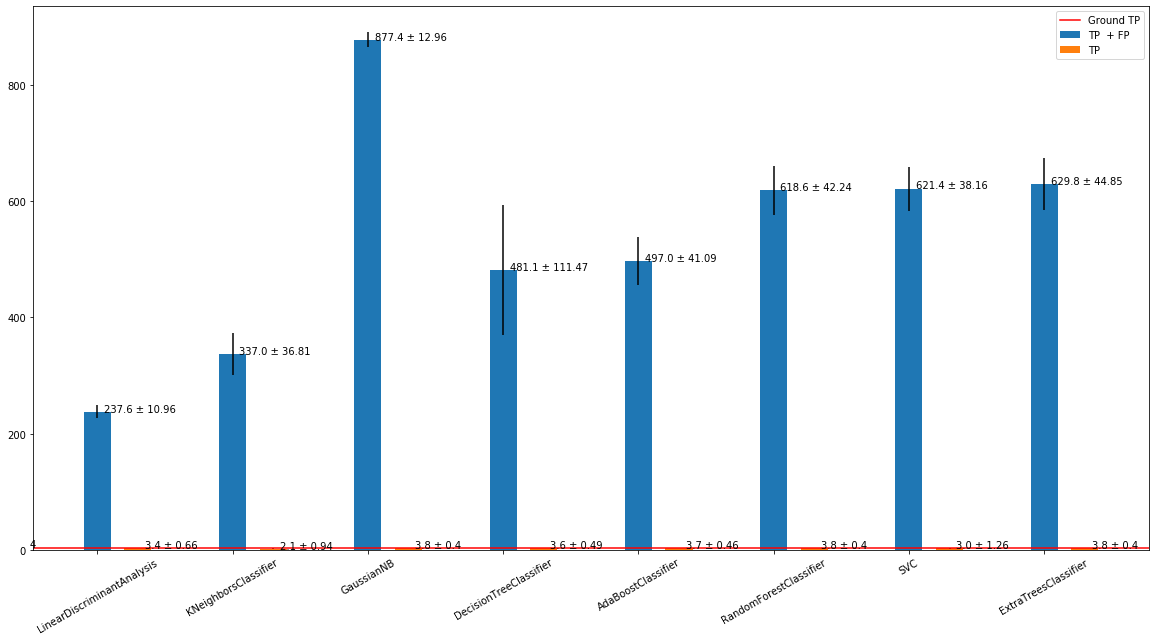

In [9]:
from src.utils.visualization import plot_trues

ground_truth = bar_plot[0][0][3]
labels = [e[0] for e in bar_plot[0]]
plot_trues(
    tps=tps, tps_tfs=tp_tfs, gt=ground_truth,
    labels=labels, tps_err=tps_err, tps_tfs_err=tp_tfs_err
)